In [1]:
from arcgis.gis import GIS
import arcgis.network as network
from arcgis.features import FeatureLayer, Feature, FeatureSet, FeatureCollection, use_proximity
import pandas as pd
import time
import datetime as dt
import keyring

In [2]:
password = keyring.get_password("arcgis", "Glodanale")
my_gis = GIS("https://www.arcgis.com", "Glodanale", password)

<Item title:"USA Major Cities" type:Feature Layer Collection owner:esri_dm>
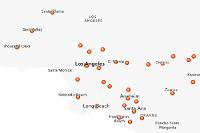

In [3]:
sample_cities = my_gis.content.search('title:"USA Major Cities" type:Feature Service', 
                                      outside_org=True)[0]
sample_cities

In [4]:
cities_fl = FeatureLayer(sample_cities.url + "/0")
type(cities_fl)

arcgis.features.layer.FeatureLayer

In [5]:
stops_cities = ['Chicago', 'Indiannapolis', 'Cleveland',
                'Columbus', 'pittsburgh', 'Buffalo']
values = "'" + "', '".join(stops_cities) + "'"
stops_layer = {'url': sample_cities.layers[0].url, 
               'filter': "ST in ('IL', 'IN', 'OH', 'PA', 'NY')  AND NAME IN ({0})".format(values)}

In [6]:
print(type(stops_layer))
print(stops_layer)
print(type(values))
print(values)

<class 'dict'>
{'url': 'https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Major_Cities/FeatureServer/0', 'filter': "ST in ('IL', 'IN', 'OH', 'PA', 'NY')  AND NAME IN ('Chicago', 'Indiannapolis', 'Cleveland', 'Columbus', 'pittsburgh', 'Buffalo')"}
<class 'str'>
'Chicago', 'Indiannapolis', 'Cleveland', 'Columbus', 'pittsburgh', 'Buffalo'


In [12]:
feature_layer_item = my_gis.content.get("USA_Major_Cities")

feature_layer = sample_cities.layers[0]
features = feature_layer.query()


index = 0

while index == 0:
    for feature in features:
        print("Feature:", feature)
        print("\n\n")
        index += 1
    #print("Geometry: ", feature.geometry)

Feature: {"geometry": {"x": -12462673.723706165, "y": 5384674.994080178, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 1, "NAME": "Ammon", "CLASS": "city", "ST": "ID", "STFIPS": "16", "PLACEFIPS": "1601990", "CAPITAL": " ", "POP_CLASS": 6, "POPULATION": 15181, "POP2010": 13816, "WHITE": 13002, "BLACK": 73, "AMERI_ES": 67, "ASIAN": 113, "HAWN_PI": 9, "HISPANIC": 884, "OTHER": 307, "MULT_RACE": 245, "MALES": 6750, "FEMALES": 7066, "AGE_UNDER5": 1468, "AGE_5_9": 1503, "AGE_10_14": 1313, "AGE_15_19": 1058, "AGE_20_24": 734, "AGE_25_34": 2031, "AGE_35_44": 1767, "AGE_45_54": 1446, "AGE_55_64": 1136, "AGE_65_74": 665, "AGE_75_84": 486, "AGE_85_UP": 209, "MED_AGE": 29.6, "MED_AGE_M": 28, "MED_AGE_F": 30.8, "HOUSEHOLDS": 4476, "AVE_HH_SZ": 3.05, "HSEHLD_1_M": 457, "HSEHLD_1_F": 648, "MARHH_CHD": 1618, "MARHH_NO_C": 1131, "MHH_CHILD": 106, "FHH_CHILD": 335, "FAMILIES": 3352, "AVE_FAM_SZ": 3.61, "HSE_UNITS": 4747, "VACANT": 271, "OWNER_OCC": 3205, "RENTER_OCC":

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [7]:
start_layer = {'url': sample_cities.layers[0].url, 
               'filter': "ST in ('MI')  AND NAME IN ('Detroit')"}

In [8]:
%%time

items = my_gis.content.search(query="OD Cost Matrix", item_type="Feature Service")
for item in items:
    item.delete()

current_time= dt.datetime.now()

result = use_proximity.connect_origins_to_destinations(origins_layer=start_layer, 
                                                        destinations_layer=stops_layer,
                                                        context={'outSR': {"wkid": 4326}},
                                                       time_of_day=current_time, 
                                                        output_name="OD Cost Matrix",
                                                        gis=my_gis)

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").
Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited, Avoid Unpaved Roads").
{"cost": 0.03}


CPU times: total: 906 ms
Wall time: 48.2 s


In [9]:
print(result)

<Item title:"OD_Cost_Matrix" type:Feature Layer Collection owner:Glodanale>


In [10]:
od_cost_matrix_sublayer = FeatureLayer.fromitem(result, layer_id=0)

In [11]:
od_df = od_cost_matrix_sublayer.query(where='1=1', as_df=True)

# filter only the required columns
od_df2 = od_df[['RouteName','OriginOID','DestinationOID','Total_Miles','StartTime','EndTime','Total_Minutes']]

In [12]:
print(od_df2)

                        RouteName  OriginOID  DestinationOID  Total_Miles  \
0     Route 1 - Detroit - Chicago       1533              63   274.211868   
1  Route 6 - Detroit - Pittsburgh       1533            2989    285.22835   
2    Route 2 - Detroit - Columbus       1533             256    326.11472   
3     Route 3 - Detroit - Buffalo       1533            2075    257.36595   
4   Route 4 - Detroit - Cleveland       1533            2385   168.141622   
5    Route 5 - Detroit - Columbus       1533            2387   203.183742   

                      StartTime                       EndTime  Total_Minutes  
0 2024-03-22 15:47:54.207000017 2024-03-22 19:04:12.884999990     256.310303  
1 2024-03-22 15:47:54.207000017 2024-03-22 20:13:16.098000050     265.364843  
2 2024-03-22 15:47:54.207000017 2024-03-22 20:48:56.678999901     302.607283  
3 2024-03-22 15:47:54.207000017 2024-03-22 20:20:40.187000036     272.766184  
4 2024-03-22 15:47:54.207000017 2024-03-22 18:29:00.109999895    